<a href="https://colab.research.google.com/github/elsyanares/DataAnalyst/blob/main/EDA_Data_Visualization_%26_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impor packages

In [1]:
# pip install pandas
# pip install numpy
# pip install datetime
import pandas as pd
import numpy as np
import datetime as dt

# Impor data dari CSV ke DataFrame

In [2]:
df = pd.read_csv('/content/Online Retail Data.csv', header=0)
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5.0,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1.0,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5.0,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1.0,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1.0,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
28536,496313,21034,REX CASH+CARRY JUMBO SHOPPER,2.0,2010-01-31 12:15:00,0.95,15013.0
28537,496313,22299,PIG KEYRING WITH LIGHT & SOUND,1.0,2010-01-31 12:15:00,1.25,15013.0
28538,496313,21790,VINTAGE SNAP CARDS,7.0,2010-01-31 12:15:00,0.85,15013.0
28539,496313,21078,SET/20 STRAWBERRY PAPER NAPKINS,4.0,2010-01-31 12:15:00,0.85,15013.0


# Data cleansing

In [3]:
df_clean = df.copy()
# membuat kolom date
df_clean['date'] = pd.to_datetime(df_clean['order_date']).dt.date
# menghapus semua baris tanpa product_name
df_clean = df_clean[~df_clean['product_name'].isna()]
# membuat semua product_name berhuruf kecil
df_clean['product_name'] = df_clean['product_name'].str.lower()
# menghapus semua baris dengan product_code atau product_name test
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]
# membuat kolom order_status dengan nilai 'cancelled' jika order_id diawali dengan huruf 'c' dan 'delivered' jika order_id tanpa awalan huruf 'c'
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')
# mengubah nilai quantity yang negatif menjadi positif karena nilai negatif tersebut hanya menandakan order tersebut cancelled
df_clean['quantity'] = df_clean['quantity'].abs()
# menghapus baris dengan price bernilai negatif
df_clean = df_clean[df_clean['price']>0]
# membuat nilai amount, yaitu perkalian antara quantity dan price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']
# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')
# mengkonversi customer_id menjadi string
df_clean['customer_id'] = df_clean['customer_id'].astype(str)
# menghapus outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
0,C493411,21539,retro spots butter dish,1.0,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,cancelled,4.25
1,493413,21724,panda and bunnies sticker sheet,1.0,2010-01-04 09:54:00,0.85,nan,2010-01-04,delivered,0.85
2,493413,84578,elephant toy with blue t-shirt,1.0,2010-01-04 09:54:00,3.75,nan,2010-01-04,delivered,3.75
3,493413,21723,alphabet hearts sticker sheet,1.0,2010-01-04 09:54:00,0.85,nan,2010-01-04,delivered,0.85
4,493414,21844,retro spot mug,36.0,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,delivered,91.80
...,...,...,...,...,...,...,...,...,...,...
27980,496313,16012,food/drink spunge stickers,24.0,2010-01-31 12:15:00,0.21,15013.0,2010-01-31,delivered,5.04
27981,496313,21034,rex cash+carry jumbo shopper,2.0,2010-01-31 12:15:00,0.95,15013.0,2010-01-31,delivered,1.90
27982,496313,22299,pig keyring with light & sound,1.0,2010-01-31 12:15:00,1.25,15013.0,2010-01-31,delivered,1.25
27983,496313,21790,vintage snap cards,7.0,2010-01-31 12:15:00,0.85,15013.0,2010-01-31,delivered,5.95


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455496 entries, 0 to 455495
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      455496 non-null  object 
 1   product_code  455496 non-null  object 
 2   product_name  455496 non-null  object 
 3   quantity      455496 non-null  int64  
 4   order_date    455496 non-null  object 
 5   price         455496 non-null  float64
 6   customer_id   455496 non-null  object 
 7   date          455496 non-null  object 
 8   order_status  455496 non-null  object 
 9   amount        455496 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 34.8+ MB


# Data visualization

## Tabel pivot (pivot table)

In [5]:
pd.pivot_table(df_clean, index='date',
               columns='order_status', values=['order_id','amount'],
               aggfunc={'order_id': pd.Series.nunique,
                        'amount': np.sum},
               fill_value=0 #untuk tidak ada nilainya
)

/tmp/ipython-input-1510695208.py:1: FutureWarning: The provided callable <function sum at 0x7d2a71f0b880> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.pivot_table(df_clean, index='date',


amount             order_id          
order_status cancelled  delivered cancelled delivered
date                                                 
2010-01-04      250.36   6971.690        11        25
2010-01-05       96.95  15195.450         4        33
2010-01-06        0.00   7292.100         0        13
2010-01-07      649.87  16898.900        32        39
2010-01-08       21.90  12929.050         1        35
2010-01-10      168.68  14179.280         3        32
2010-01-11      223.87  28699.650         5        45
2010-01-12       93.70  13034.870         4        33
2010-01-13      204.27  16765.600        14        26
2010-01-14      523.24  28363.240        21        55
2010-01-15      119.00   9821.880         3        39
2010-01-17       12.30  15073.360         1        40
2010-01-18       91.98  17943.200         5        39
2010-01-19       56.70  23267.941         2        40
2010-01-20     1147.30  12557.090        32        31
2010-01-21      424.07  14213.270        15        45
2010-01-22      168.89  15045.400         4        33
2010-01-24       26.39  14687.670         2        49
2010-01-25       87.24  20570.710         5        55
2010-01-26      957.17  16365.420        30        57
2010-01-27      223.22  21499.980        16        51
2010-01-28      478.91  18727.320        11        55
2010-01-29      860.86  17917.541        22        44
2010-01-31       59.85   7466.700         2        21

## Grafik batang (bar chart)

In [6]:
df_status_summary = df_clean.groupby('order_status', as_index=False).agg(order_cnt=('order_id','nunique'),total_amount=('amount','sum'))
df_status_summary

,order_status,order_cnt,total_amount
0,cancelled,245,6946.720
1,delivered,935,385487.312


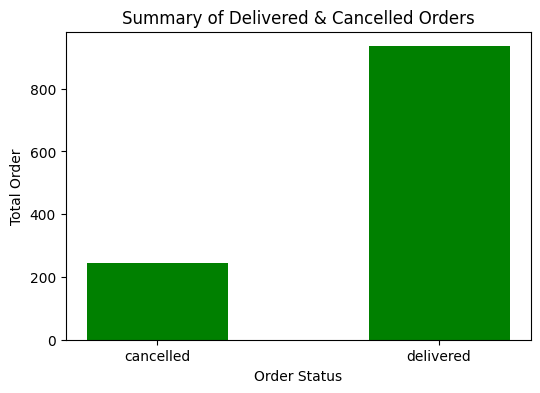

In [8]:
# pip install matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))
plt.bar(df_status_summary['order_status'], df_status_summary['order_cnt'],
        color='green', width=0.5)
plt.xlabel('Order Status')
plt.ylabel('Total Order')
plt.title('Summary of Delivered & Cancelled Orders')
plt.show()

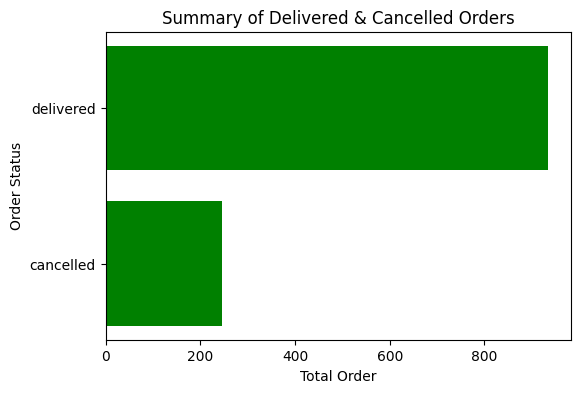

In [9]:
# pip install matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))
plt.barh(df_status_summary['order_status'], df_status_summary['order_cnt'],
         color='green')
plt.xlabel('Total Order')
plt.ylabel('Order Status')
plt.title('Summary of Delivered & Cancelled Orders')
plt.show()

## Histogram

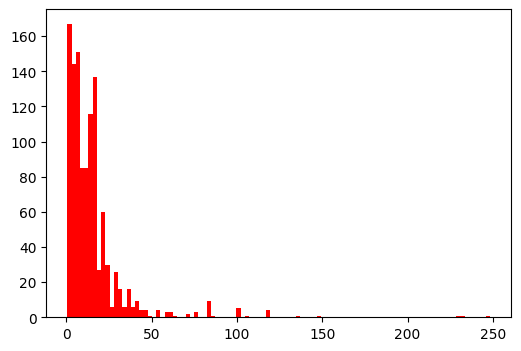

In [12]:
# pip install matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
plt.hist(df_clean.loc[df_clean['product_name'].str.contains('tea'), 'amount'], 100,
         color='red')
plt.show()

## Grafik garis (line chart)

In [13]:
df_date_summary = df_clean.groupby('date', as_index=False).agg(order_cnt=('order_id','nunique'))
df_date_summary

,date,order_cnt
0,2010-01-04,36
1,2010-01-05,37
2,2010-01-06,13
3,2010-01-07,71
4,2010-01-08,36
5,2010-01-10,35
6,2010-01-11,50
7,2010-01-12,37
8,2010-01-13,40
9,2010-01-14,76


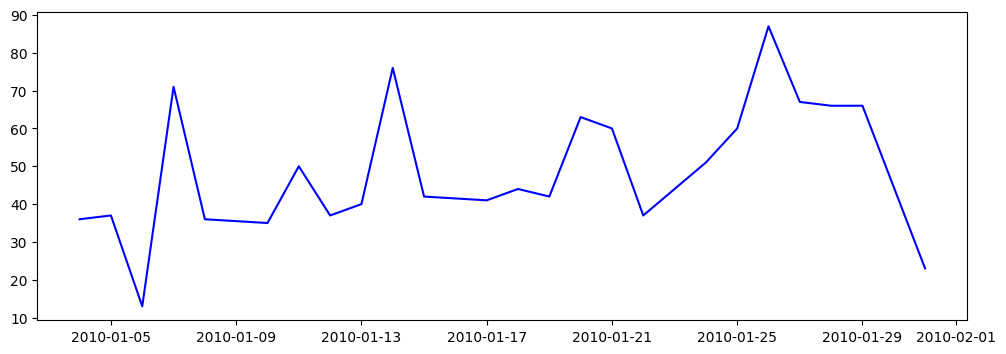

In [15]:
# pip install matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
plt.plot('date', 'order_cnt', data=df_date_summary, color='blue', linestyle='-')
plt.show()

## Grafik lingkaran (pie chart)

In [16]:
df_status_summary

,order_status,order_cnt,total_amount
0,cancelled,245,6946.720
1,delivered,935,385487.312


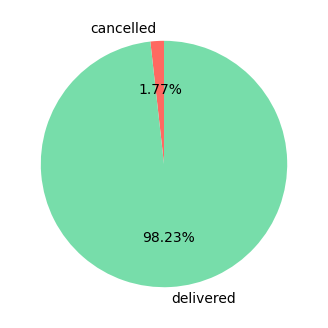

In [17]:
# pip install matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
plt.pie(df_status_summary['total_amount'], labels=df_status_summary['order_status'],
        startangle=90, autopct='%1.2f%%', colors=['#FF6961','#77DDAA'])
plt.show()

## Grafik sebar (scatterplot)

In [18]:
df_tea_only = df_clean[df_clean['product_name'].str.contains('tea')]
df_tea_only

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
8,493414,21527,retro spot traditional teapot,12.0,2010-01-04 10:28:00,6.95,14590.0,2010-01-04,delivered,83.40
10,C493415,21527,retro spot traditional teapot,3.0,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,cancelled,23.85
20,493427,79000,moroccan tea glass,12.0,2010-01-04 10:43:00,0.85,13287.0,2010-01-04,delivered,10.20
56,C493430,21527,retro spot traditional teapot,1.0,2010-01-04 11:43:00,7.95,14680.0,2010-01-04,cancelled,7.95
100,493432,22072,tea cup and saucer retro spot,2.0,2010-01-04 12:30:00,3.75,14680.0,2010-01-04,delivered,7.50
...,...,...,...,...,...,...,...,...,...,...
27939,496309,22027,tea party birthday card,24.0,2010-01-31 12:03:00,0.42,13093.0,2010-01-31,delivered,10.08
27948,496309,22139,retro spot tea set ceramic 11 pc,2.0,2010-01-31 12:03:00,4.95,13093.0,2010-01-31,delivered,9.90
27951,496309,47566B,tea time party bunting,10.0,2010-01-31 12:03:00,4.65,13093.0,2010-01-31,delivered,46.50
27954,496309,22046,tea party wrapping paper,25.0,2010-01-31 12:03:00,0.42,13093.0,2010-01-31,delivered,10.50


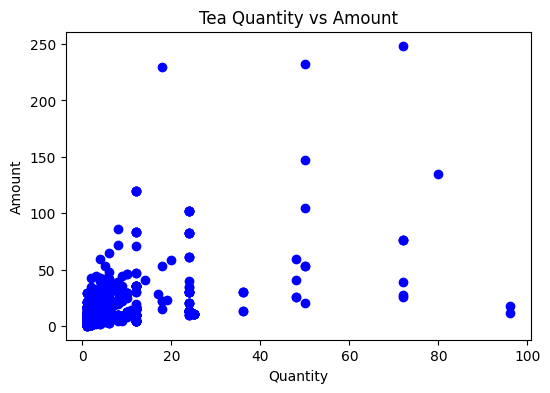

In [19]:
# pip install matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
plt.scatter(df_tea_only['quantity'], df_tea_only['amount'], c='blue', marker='o')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.title('Tea Quantity vs Amount')
plt.show()

## Grafik kotak-garis (boxplot)

In [20]:
df_tea_only

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
8,493414,21527,retro spot traditional teapot,12.0,2010-01-04 10:28:00,6.95,14590.0,2010-01-04,delivered,83.40
10,C493415,21527,retro spot traditional teapot,3.0,2010-01-04 10:33:00,7.95,14590.0,2010-01-04,cancelled,23.85
20,493427,79000,moroccan tea glass,12.0,2010-01-04 10:43:00,0.85,13287.0,2010-01-04,delivered,10.20
56,C493430,21527,retro spot traditional teapot,1.0,2010-01-04 11:43:00,7.95,14680.0,2010-01-04,cancelled,7.95
100,493432,22072,tea cup and saucer retro spot,2.0,2010-01-04 12:30:00,3.75,14680.0,2010-01-04,delivered,7.50
...,...,...,...,...,...,...,...,...,...,...
27939,496309,22027,tea party birthday card,24.0,2010-01-31 12:03:00,0.42,13093.0,2010-01-31,delivered,10.08
27948,496309,22139,retro spot tea set ceramic 11 pc,2.0,2010-01-31 12:03:00,4.95,13093.0,2010-01-31,delivered,9.90
27951,496309,47566B,tea time party bunting,10.0,2010-01-31 12:03:00,4.65,13093.0,2010-01-31,delivered,46.50
27954,496309,22046,tea party wrapping paper,25.0,2010-01-31 12:03:00,0.42,13093.0,2010-01-31,delivered,10.50


<Axes: ylabel='quantity'>

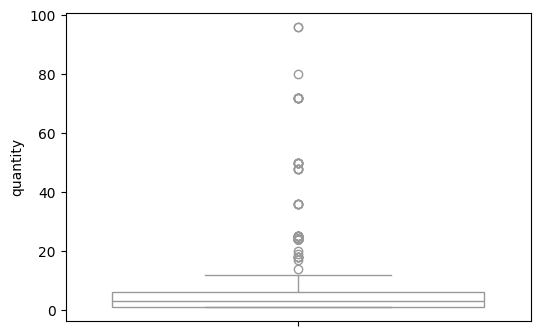

In [21]:
# pip install seaborn
import seaborn as sns
fig = plt.figure(figsize=(6, 4))
sns.boxplot(data=df_tea_only, y='quantity', color='white')

<Axes: ylabel='amount'>

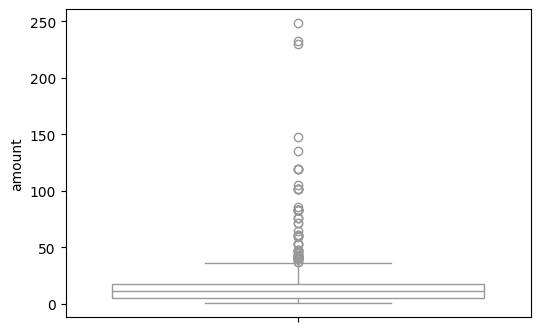

In [22]:
# pip install seaborn
import seaborn as sns
fig = plt.figure(figsize=(6, 4))
sns.boxplot(data=df_tea_only, y='amount', color='white')

## Heatmap - Correlation

<Axes: >

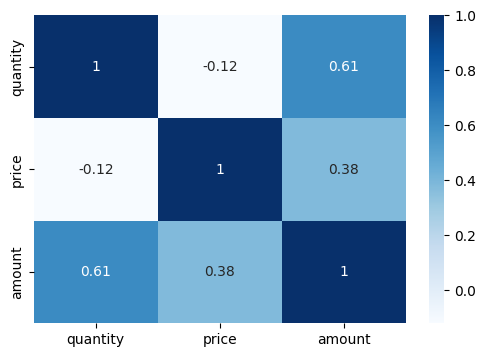

In [24]:
# pip install seaborn
import seaborn as sns
fig = plt.figure(figsize=(6, 4))
# Select only numeric columns for correlation calculation
numeric_df_clean = df_clean.select_dtypes(include=np.number)
sns.heatmap(numeric_df_clean.corr(), cmap='Blues', annot=True)